# Classification à l'aide de propagation de front sur graphe

Ce notebook présente l'implémentation d'une méthode de classification semi supervisé à l'aide de EdP sur graphe venant de la thèse de M. Touttain.
Ce travail est le notebook de mon projet de fin d'étude disponible ici. Tous les commentaires sur les résultats sont disponibles dans le rapport disponible ici : https://github.com/theot-student/EdP-sur-graphes

Le but de se notebook est d'implémenter un algorithme de classification semi-supervisé en utilisant l'équation eikonale sur graphe. L'algorithme est dit semi supervisé car il a besoin de connaître un certain nombre d'éléments labélisés initialement pour fonctionner. Nous allons voir comment utiliser cet algorithme pour classifier les base de données MNIST et OPTDIGITS.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import time
from sklearn.neighbors import NearestNeighbors
from keras.datasets import mnist
import networkx as nx
from sklearn.datasets import fetch_openml
from sklearn.metrics.pairwise import euclidean_distances, PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import defaultdict
from scipy.stats import wasserstein_distance

## 1. Implémentation pour la création du graphe des données

Dans cette partie comprend l'implémentation d'un graphe des k-plus proches voisins à partir d'une liste de distances. Les distances doivent être représenté par une matrice où chaque ligne i, et chaque colonne j représenté l'élément i ou j de la base de données. Ainsi, la cellule i,j donne la distance entre les éléments i et j.

In [2]:
sigma = 0.5
def computeWeight(u,v,distances,sigma):
  return 1 / distances[u,v]

In [3]:
def nearest_neighbors_graph(k, data, labels, distances, weightFunction):
  #Paramètres :
  # int k : nombre de voisins
  # tab data : tableau contenant les données
  # tab labels : tableau contenant les labels
  # matrice distances : matrice N*N des distances entre les éléments
  # function weightFunction : fonction d'attribution des poids

  G = nx.Graph()

  # Ajouter les nœuds
  for i in range(len(data)):
      G.add_node(i, label=labels[i])

  # Ajouter les arêtes
  for i in range(len(data)):
      nearest_neighbors = np.argsort(distances[i])[1:k+1]  # On récupère les k plus proches voisins
      for neighbor in nearest_neighbors:
          G.add_edge(i, neighbor, weight=weightFunction(i,neighbor,distances,sigma))
  return G

In [4]:
k = 10  # Nombre de voisins

## 2. Implémentation du modèle de classification

Nous implémentons maintenant l'algorithme de classification semi-supervisé vu dans le rapport. Nous utilisons un potentiel égal à 1 et nous utilisons la solution locale pour p=1.

In [5]:
def P(vertex):
  return 1

In [6]:
def smaller(a ,b) :
  if a == "inf" and b != "inf":
    return False
  else :
    if b == "inf" :
      return True
    else :
      return a < b

In [7]:
def smallerEqual(a ,b) :
  if a == "inf" and b != "inf":
    return False
  else :
    if b == "inf" :
      return True
    else :
      return a <= b

In [8]:
def sortingFunc(x, f):
  if f[x] == "inf" :
    return 100000
  else :
    return f[x]

In [9]:
def solutionLocaleL1(vertex, edges, f, dataGraph) :
  sortedVertex = []
  sortedWeight = []
  for edge in edges :
    sortedVertex.append(edge[1])
    sortedWeight.append(dataGraph.edges[vertex,edge[1]]["weight"])

  sort_index = [i for i, x in sorted(enumerate(sortedVertex), key=lambda x: sortingFunc(x[1], f))]
  sortedVertex = np.array(sortedVertex)
  sortedWeight = np.array(sortedWeight)
  sortedVertex = sortedVertex[sort_index]
  sortedWeight = sortedWeight[sort_index]

  #calcul de la solution locale
  n = len(sortedVertex)
  m = 0
  x = "inf"
  if f[sortedVertex[0]] == "inf" :
    return "inf"
  while m <= n-1 and smallerEqual(f[sortedVertex[m]],x) :
    sumha = 0
    sumh = 0
    for i in range(m+1) :
      h = np.sqrt(sortedWeight[i])
      sumha += h * f[sortedVertex[i]]
      sumh += h
    m += 1
    x = (sumha + P(vertex)) / sumh

  return x

In [10]:

def minSearch(edges, A, f) :
  argMin = edges[0][1]
  candidates = [edge[1] for edge in edges if edge[1] in A]
  for vertex in candidates :
    if smaller(f[vertex],f[argMin]) :
      argMin = vertex
  return argMin

In [11]:
def propagationDeFront(dataGraph, S0, solutionLocal) :
  #Algorithme de propagation de front utilisant l'équation eikonale sur graphe.
  #Paramètres :
  # NetworkXGraph dataGraph : graph pondéré des plus proches voisins contenant les labels
  # set S0 : ensembles des noeuds de départ. Seuls les labels de ces noeuds seront accéder dans l'algorithme
  # function solutionLocal : fonction permettant de calculer la solution locale en un point

  l = 0
  #init
  lab = {}
  s = {}
  f = {}
  for vertex in list(dataGraph.nodes) :
    if vertex in S0 :
      lab[vertex] = dataGraph.nodes[list(dataGraph.nodes)[vertex]]['label']
      f[vertex] = 0
    else :
      lab[vertex] = -1
      f[vertex] = "inf"
      s[vertex] = "inf"
  A = S0.copy()
  NB = set()
  for vertex in A :
    for neighbor in list(dataGraph.adj[vertex]):
      if neighbor not in A :
         NB.add(neighbor)
  FA = set(dataGraph.nodes).difference(A.union(NB))
  for vertex in NB :
    f[vertex] = solutionLocal(vertex, list(dataGraph.edges(vertex)), f,dataGraph)
  NB = sorted(list(NB), key=lambda x : sortingFunc(x, f))
  for u in NB:
    v = minSearch(list(dataGraph.edges(u)), A, f)
    lab[u] = lab[v]

  #main loop
  while len(NB) > 0:
    l +=1
    u = NB[0]
    A.add(u)
    NB.remove(u)
    for vertex in list(dataGraph.adj[u]) :
      if not(vertex in A) :
        t = solutionLocal(vertex, list(dataGraph.edges(vertex)), f, dataGraph)
        #print("sol locale ",t,"f ",f[vertex])
        if smaller(t, f[vertex]) :
          f[vertex] = t
          if vertex in FA :
            FA.remove(vertex)
            NB.append(vertex)
          else :
            NB = sorted(list(NB), key=lambda x : sortingFunc(x, f))

          f_w = f[u] / dataGraph.edges[u,vertex]["weight"]

          if smaller(f_w, s[vertex]) :
            s[vertex] = f_w
            lab[vertex] = lab[u]
  return lab

On implémente également les métrique pour vérifier les résultats.

In [12]:
def tauxDeClassification(labels_predits, labels_reel):
    true = 0
    false = 0
    non_assigné = 0
    values = list(labels_predits.values())
    for i in range(len(labels_predits)):
      if  values[i] == labels_reel[i] :
        true += 1
      else :
        false += 1
      if values[i] == -1 :
        non_assigné +=1
    taux = true / (true + false)
    return true, false, non_assigné , taux

In [13]:
def matriceDeConfusion(lab,y):

  lab_array = np.array(list(lab.values()))

  cm = confusion_matrix(y, lab_array)

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

In [14]:
def metrics(lab,y):

  lab_array = np.array(list(lab.values()))


  lab_array[lab_array == -1] = 0  # Remplace -1 par 0 pour éviter les erreurs


  # Calculer les métriques
  accuracy = accuracy_score(y, lab_array)
  precision = precision_score(y, lab_array, average='weighted', zero_division=0)  # Gestion des cas de division par zéro
  recall = recall_score(y, lab_array, average='weighted', zero_division=0)
  f1 = f1_score(y, lab_array, average='weighted', zero_division=0)

  # Afficher les métriques
  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")

  # Afficher le rapport de classification complet
  print(classification_report(y, lab_array, zero_division=0))

## 3. Application MNIST

Nous allons tout d'abords nous intéresser à la base de données MNIST.

### Importation des données MNIST

In [ ]:
N = 30000 # Nombre de données

In [ ]:
(X0, Y0), (X1, Y1) = mnist.load_data()
# On met le type des images en float.
X0 = X0.astype('float32')
X1 = X1.astype('float32')
# On met les images sous la forme d'un vecteur.
X0 = X0.reshape(60000, 784)
X1 = X1.reshape(10000, 784)
# On normalise les images.
X0 = X0 / 255.0
X1 = X1 / 255.0

5


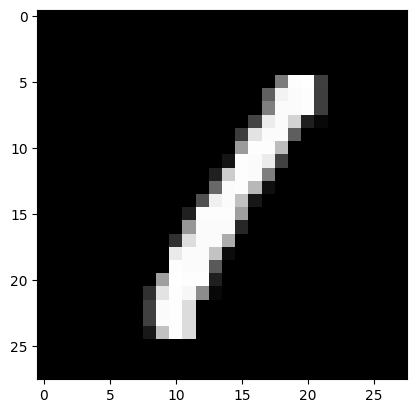

In [ ]:
#Affichage de la 3ème image
n = 3
Y0_ = pd.get_dummies(Y0).values
Y1_ = pd.get_dummies(Y1).values
plt.imshow(X0[n, :].reshape(28, 28), cmap="gray")
print(Y0[0])

In [ ]:
mnist_data = X0[:N]
mnist_labels = Y0[:N]

In [ ]:
np.unique(mnist_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([2961, 3423, 2948, 3073, 2926, 2709, 2975, 3107, 2875, 3003]))

In [ ]:
PAIRWISE_DISTANCE_FUNCTIONS

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances(X, Y=None)>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'haversine': <function sklearn.metrics.pairwise.haversine_distances(X, Y=None)>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'precomputed': None,
 'nan_euclidean': <function sklearn.metrics.pairwise.nan_euclidean_distances(X, Y=None, *, squared=False, missing_values=nan, copy=True)>}

In [ ]:
mnist_distances = pairwise_distances(mnist_data, metric='euclidean')

Création du graphe des plus proches voisins.

In [ ]:
k = 10
mnist_G = nearest_neighbors_graph(k, mnist_data, mnist_labels, mnist_distances, computeWeight)

### Visualisation du graphe

In [ ]:
#pos = nx.spring_layout(G, seed=42)
#nx.draw(G, pos, with_labels=False, node_size=1)

In [ ]:
subgraph = mnist_G.subgraph(list(mnist_G.nodes)[:500])

In [ ]:
# Générer un mapping des couleurs
unique_labels = [0,1,2,3,4,5,6,7,8,9]
color_map = {label: plt.cm.tab10(i) for i, label in enumerate(unique_labels)}  # Associer une couleur à chaque label

# Créer une liste de couleurs pour chaque nœud
node_colors = [color_map[mnist_labels[node]] for node in subgraph.nodes()]

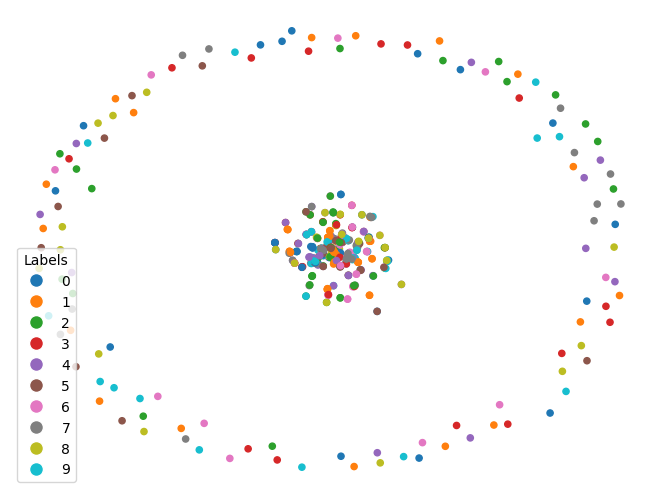

In [ ]:
pos = nx.spring_layout(subgraph)  # Générer une disposition des nœuds
nx.draw(subgraph, pos, node_color=node_colors, with_labels=False, node_size=20, font_color='white')


handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
    for label, color in color_map.items()
]

# Ajouter la légende en bas à gauche
plt.legend(handles, color_map.keys(), title="Labels", loc='lower left', bbox_to_anchor=(0, 0))
plt.show()

In [ ]:
mnist_G.nodes[list(mnist_G.nodes)[0]]['label']

5

In [ ]:
list(mnist_G.edges(0))

[(0, 1757),
 (0, 156),
 (0, 2699),
 (0, 2983),
 (0, 3256),
 (0, 4035),
 (0, 1620),
 (0, 326),
 (0, 902),
 (0, 4305),
 (0, 581),
 (0, 988),
 (0, 1793),
 (0, 2723),
 (0, 3716),
 (0, 3821),
 (0, 3839),
 (0, 3995),
 (0, 4229),
 (0, 4325)]

In [ ]:
nx.is_connected(mnist_G)

True

### Application

Dans cette expérience, on regarde les taux de classification pour 1% de germes selon si on a utilisé la distance Euclidienne ou Cosinus. Je vous conseille de ne pas tester de votre coté car la propagation de front peut prendre plus d'une heure.

In [ ]:
Ngermes = N // 100

In [ ]:
mnist_S0 = set(random.sample(list(mnist_G.nodes),Ngermes))

In [ ]:
mnist_lab = propagationDeFront(mnist_G, mnist_S0, solutionLocaleL1)

In [ ]:
#lab.values()

In [ ]:
true,false,non_assigné, taux = tauxDeClassification(mnist_lab, mnist_labels)
print("true = ", true)
print("false = ", false)
print("non_assignés = ", non_assigné)
print(taux)

true =  24467
false =  5533
non_assignés =  0
0.8155666666666667


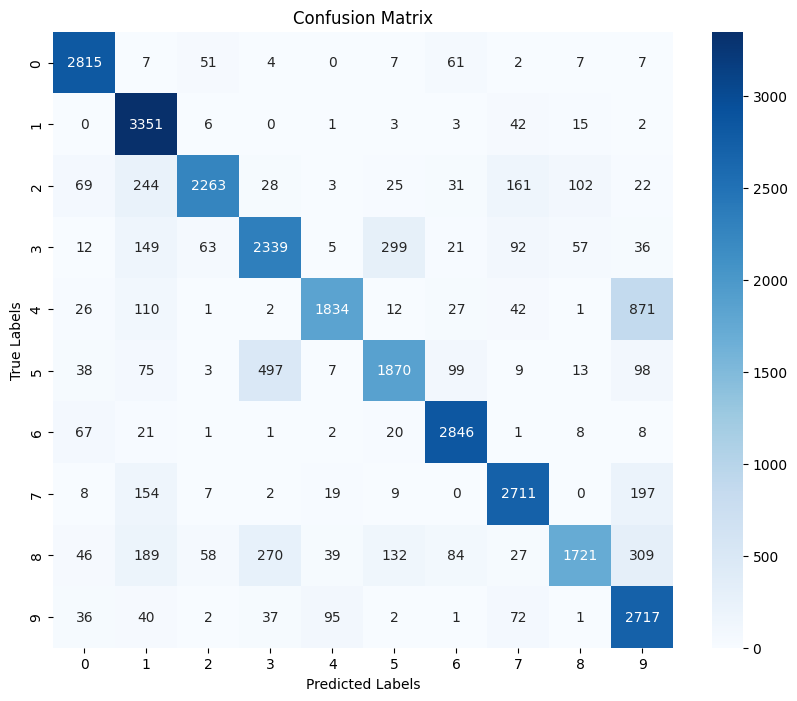

In [ ]:
matriceDeConfusion(mnist_lab,mnist_labels)

In [ ]:
np.unique(mnist_labels[list(mnist_S0)], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([31, 28, 23, 29, 21, 37, 24, 33, 36, 38]))

## 4. Application OPTDIGITS

Nous testons maintenant notre algorithme sur la base de données OPTDIGITS.

### Création du graphe

In [15]:
from sklearn.datasets import fetch_openml

optdigits = fetch_openml(name='optdigits', version=1, parser='auto')

# Récupérer les features (X) et les labels (y)
opt_X = np.array(optdigits.data)
opt_y = np.array(optdigits.target)

In [16]:
np.unique(opt_y, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([554, 571, 557, 572, 568, 558, 558, 566, 554, 562]))

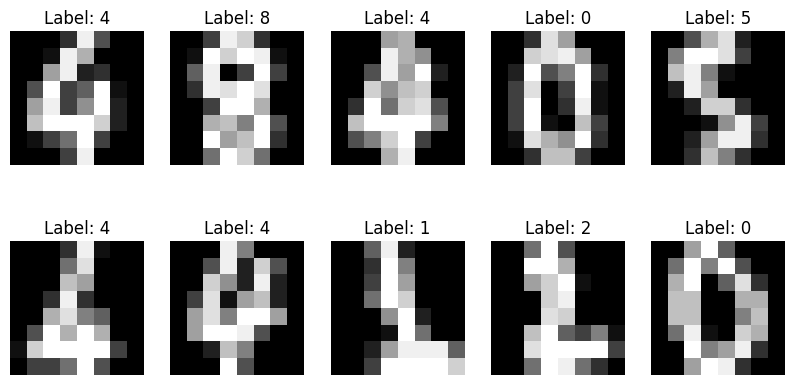

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    index = np.random.randint(len(opt_X))
    image = opt_X[index].reshape(8, 8)  # Reshape en matrice 8x8
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Label: {opt_y[index]}")
    ax.axis("off")

plt.show()

In [18]:
opt_distances = euclidean_distances(opt_X)

In [19]:
k = 10

In [20]:
opt_G = nearest_neighbors_graph(k, opt_X, opt_y, opt_distances, computeWeight)

### Application

On fait une première expérience simple pour 1% de germes.

In [21]:
Ngermes = len(opt_X) // 100
Ngermes

56

In [22]:
opt_S0 = set(random.sample(list(opt_G.nodes),Ngermes))

In [23]:
opt_lab = propagationDeFront(opt_G, opt_S0, solutionLocaleL1)

In [24]:
true,false,non_assigné, taux = tauxDeClassification(opt_lab, opt_y)
print("true = ", true)
print("false = ", false)
print("non_assignés = ", non_assigné)

true =  5068
false =  552
non_assignés =  0


In [25]:
print(taux)

0.9017793594306049


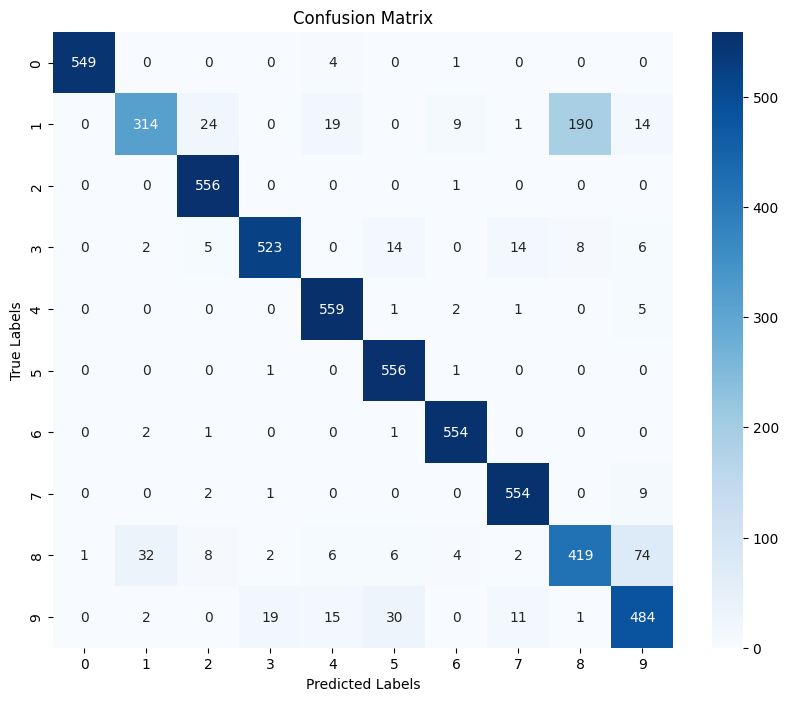

In [26]:
matriceDeConfusion(opt_lab,opt_y)

## 5. Répétition de l'expérience

Nous allons maintenant répéter l'expérience sur la base de données OPTDIGITS pour différents choix de germes aléatoires. Chaque expérience est répété 50 fois pour plus de précision dans les résultats.

### 1% de germes

In [27]:
nbExp = 10 #50 normalement mais re effectué avec 10 par manque de temps
Ngermes = len(opt_X) // 100
somme_taux_moyen = 0
somme_taux_moyen_carrée = 0
for i in range(nbExp):
  opt_S0 = set(random.sample(list(opt_G.nodes),Ngermes))
  opt_lab = propagationDeFront(opt_G, opt_S0, solutionLocaleL1)
  true, false, non_assigné, taux = tauxDeClassification(opt_lab, opt_y)
  #print(taux)
  somme_taux_moyen += taux
  somme_taux_moyen_carrée += taux**2

In [28]:
taux_moyen = somme_taux_moyen / nbExp
print("taux moyen = ", taux_moyen)
variance_taux = somme_taux_moyen_carrée / nbExp - taux_moyen**2
print("variance = ", variance_taux)

taux moyen =  0.8922419928825622
variance =  0.0011576993705754157


### 5% de germes

In [29]:
Ngermes = len(opt_X) // 20
somme_taux_moyen = 0
somme_taux_moyen_carrée = 0
for i in range(nbExp):
  opt_S0 = set(random.sample(list(opt_G.nodes),Ngermes))
  opt_lab = propagationDeFront(opt_G, opt_S0, solutionLocaleL1)
  true, false, non_assigné, taux = tauxDeClassification(opt_lab, opt_y)
  print(taux)
  somme_taux_moyen += taux
  somme_taux_moyen_carrée += taux**2

0.9384341637010676
0.8973309608540925
0.9412811387900356
0.9444839857651246
0.9364768683274022
0.947508896797153
0.950711743772242
0.9462633451957295
0.949288256227758
0.906761565836299


In [30]:
taux_moyen = somme_taux_moyen / nbExp
print("taux moyen = ", taux_moyen)
variance_taux = somme_taux_moyen_carrée / nbExp - taux_moyen**2
print("variance = ", variance_taux)

taux moyen =  0.9358540925266903
variance =  0.00030867928471023376


### 10% de germes

In [31]:
Ngermes = len(opt_X) // 10
somme_taux_moyen = 0
somme_taux_moyen_carrée = 0
for i in range(nbExp):
  opt_S0 = set(random.sample(list(opt_G.nodes),Ngermes))
  opt_lab = propagationDeFront(opt_G, opt_S0, solutionLocaleL1)
  true, false, non_assigné, taux = tauxDeClassification(opt_lab, opt_y)
  print(taux)
  somme_taux_moyen += taux
  somme_taux_moyen_carrée += taux**2

0.951779359430605
0.9548042704626335
0.9398576512455517
0.945017793594306
0.9354092526690392
0.9268683274021352
0.9501779359430605
0.9393238434163701
0.9633451957295374
0.9368327402135231


In [32]:
taux_moyen = somme_taux_moyen / nbExp
print("taux moyen = ", taux_moyen)
variance_taux = somme_taux_moyen_carrée / nbExp - taux_moyen**2
print("variance = ", variance_taux)

taux moyen =  0.9443416370106762
variance =  0.00010472131811911645


## 6. Analyse de l'influence des germes

Dans cette partie, nous allons regarder l'influence des germes notamment lorsqu'elles favorise un label en particulier.

In [ ]:
Ngermes = len(opt_X) // 100

In [ ]:
label_dict = defaultdict(list)
for node, data in opt_G.nodes(data=True):
    label_dict[data['label']].append(node)

In [ ]:
#opt_S0 = set()
#opt_S0.update(set(random.sample(list(label_dict['0']),2)))
#opt_S0.update(set(random.sample(list(label_dict['1']),2)))
#opt_S0.update(set(random.sample(list(label_dict['2']),2)))
#opt_S0.update(set(random.sample(list(label_dict['3']),2)))
#opt_S0.update(set(random.sample(list(label_dict['4']),2)))
#opt_S0.update(set(random.sample(list(label_dict['5']),2)))
#opt_S0.update(set(random.sample(list(label_dict['6']),2)))
#opt_S0.update(set(random.sample(list(label_dict['7']),2)))
#opt_S0.update(set(random.sample(list(label_dict['8']),2)))
#opt_S0.update(set(random.sample(list(label_dict['9']),2)))
#opt_S0.update(set(random.sample(list(label_dict['0']),Ngermes-20)))

In [ ]:
np.unique(opt_y[list(opt_S0)], return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([3, 9, 6, 4, 7, 5, 8, 4, 8, 2]))

In [ ]:
somme_taux_moyen = 0
somme_taux_moyen_carrée = 0

for i in range(10):
  #init S0
  opt_S0 = set()
  opt_S0.update(set(random.sample(list(label_dict['0']),2)))
  opt_S0.update(set(random.sample(list(label_dict['1']),2)))
  opt_S0.update(set(random.sample(list(label_dict['2']),2)))
  opt_S0.update(set(random.sample(list(label_dict['3']),2)))
  opt_S0.update(set(random.sample(list(label_dict['4']),2)))
  opt_S0.update(set(random.sample(list(label_dict['5']),2)))
  opt_S0.update(set(random.sample(list(label_dict['6']),2)))
  opt_S0.update(set(random.sample(list(label_dict['7']),2)))
  opt_S0.update(set(random.sample(list(label_dict['8']),2)))
  opt_S0.update(set(random.sample(list(label_dict['9']),2)))
  opt_S0.update(set(random.sample(list(label_dict[str(i)]),Ngermes-20)))

  #algo
  opt_lab = propagationDeFront(opt_G, opt_S0, solutionLocaleL1)
  true, false, non_assigné, taux = tauxDeClassification(opt_lab, opt_y)
  somme_taux_moyen += taux
  somme_taux_moyen_carrée += taux**2


In [ ]:
taux_moyen = somme_taux_moyen / 10
print("taux moyen = ", taux_moyen)
variance_taux = somme_taux_moyen_carrée / 10 - taux_moyen**2
print("variance = ", variance_taux)

taux moyen =  0.7616192170818505
variance =  0.011036379035219812


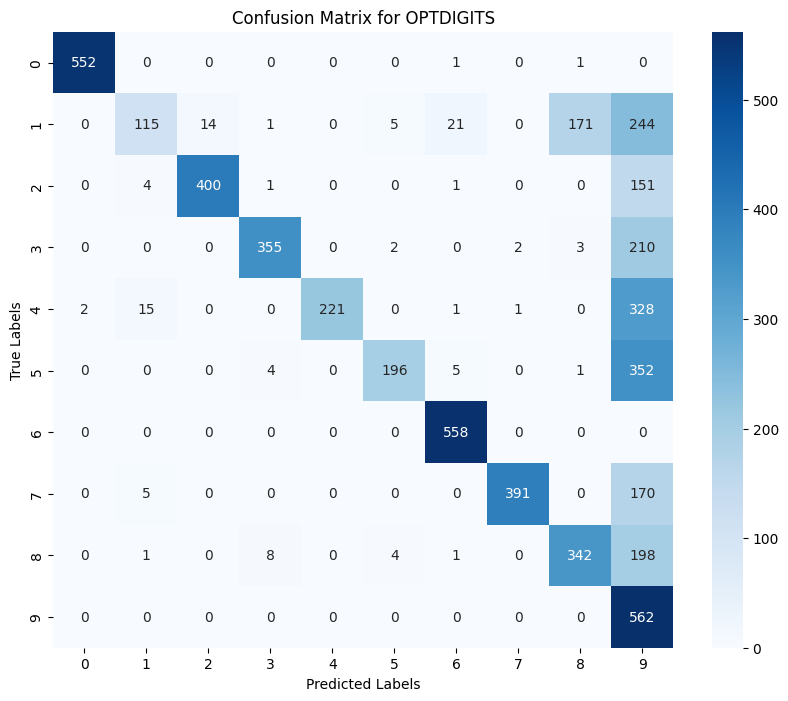

In [ ]:
matriceDeConfusion(opt_lab,opt_y)

In [ ]:
metrics(opt_lab,opt_y)

Accuracy: 0.9272241992882563
Precision: 0.9273958949989828
Recall: 0.9272241992882563
F1-score: 0.9263250798230411
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       554
           1       0.87      0.92      0.89       571
           2       0.94      0.96      0.95       557
           3       0.94      0.95      0.95       572
           4       0.99      0.93      0.96       568
           5       0.92      0.89      0.90       558
           6       0.95      0.97      0.96       558
           7       0.90      0.99      0.95       566
           8       0.90      0.89      0.89       554
           9       0.90      0.76      0.82       562

    accuracy                           0.93      5620
   macro avg       0.93      0.93      0.93      5620
weighted avg       0.93      0.93      0.93      5620

